In [2]:
%pylab inline
import IPython.display

Populating the interactive namespace from numpy and matplotlib


In [3]:
import random

# Autonomous SDE
$$
    X(t) = X_{0} + \int^{t}_{0} f(X(s))ds + \int^{t}_{0} g(X(s))dW(s)
$$

## Corresponding Euler Maruyama Method

$$
    X_{j} = X_{j-1} + f(X_{j-1})\Delta t + g(X_{j-1})(W(\tau_{j}) - W(\tau_{j-1}))
$$
If $g \equiv 0$ then we get forward Euler (Deterministic case):

$$
    U^{n+1} = U^{n} + f(U^{n})
$$


Applying to the linear SDE: 
$$
    dX(t) = \lambda X(t)dt + \mu X(t)dW(t)
$$
Where $f(X) = \lambda X$ and $g(X) = \mu X$

And so the corresponding E-M Method to the linear SDE: 
$$
    X_{j} = X_{j-1} + \lambda X_{j-1}\Delta t + \mu X_{j-1}(W(\tau_{j}) - W(\tau_{j-1}))
$$

A detailed explanation of the Euler Maruyama method applied to a scalar, autonomous SDE can be found http://dx.doi.org/10.1137/S0036144500378302 Higham, D.J., 2001. An algorithmic introduction to numerical simulation of stochastic differential equations. SIAM review, 43(3), pp.525-546. 


## Coupled diffusion


An example that can be modelled as a coupled diffusion process is protein conformation.  The configuration of a protein can change due to fluctuations in the environment, such as temperature. A change in the configuration of the protein causes a change in the interaction between amino acids, and so a change in consequent behaviour, however the underlying amino acid sequence remains thesame. The change in configuration of the protein can be reversed and the original behaviour of the protein is restored. However this change can occur abruptly which can be viewed analogously as a reaction occurring in a given interval independent of other reactions. The process can also happen more than once where a rate can be associated to the change in state. Thus the switching between states can be modelled as a coupled  diffusion process.

From this we can consider two linear, diffusion approximated, SDE denoted as $X_{1}$ and $X_{2}$:

$$
    dX_{1}(t) = \mu_{1}dt + \sigma_{1}dW_{t}
$$

$$
    dX_{2}(t) = \mu_{2}(t)dt + \sigma_{2}dW_{t}
$$

So the corresponding E-M equations: 

$$
    X_{1,j + 1} = X_{1,j} + \mu_{1}\Delta t + \sigma_{1} dW_{t}
$$

$$
    X_{2,j + 1} = X_{2,j} + \mu_{2}\Delta t + \sigma_{2} dW_{t}
$$

If we couple the diffusion processes into one process so that we have a situation where
$$
    X_{j + 1} = X_{j} + \mu_{\xi}\Delta t + \sigma_{\xi} dW_{t} \qquad \qquad \qquad (1)
$$

$\xi$ denotes the state of our diffusion where it can only have a value of 1 or 2.


However to account for this, a modification to the algorithm need to be made in order to add the switching between two diffusive states. A notable change would be the inclusion of switching times. The set of switching times are generated by taking an exponential random variable scaled by a rate of switching. Using a uniformly distributed random number, $r$, from $[0, 1)$ an inverse time transformation must be made so that $r$ is Poisson distributed. From this we can calculate $\delta s = 1/q_{j,k} ln (r)$ where $q_{j,k}$ denotes the switching from state $j$ to $k$ so the next switching time follows $s_{i} = s + \delta s$; $s$ is the current switching time. In addition, the chosen rate of switching depends on the current state of the system. For example, if the system is in state 1, then the corresponding rate used would be $q_{1,2}$. The same argument applies if the system was in state 2. 

It can be seen that, if the particle was in state 1 then it must switch to state 2. In this way, a relation where state 1 corresponds to the odd numbers in a range and even numbers to represent state 2. The number of switching times depend on whether the latest generated switching time is less than $t_{final}$.

For a set of switching times, the position of the particle in a given time frame using eq. 1. The algorithm uses the idea of setting a desired fixed time step $dt = t_{final}/N$, however a problem occurs if the switching time lies between $t < s < t + dt$, where $t$ is the current time. This can be accounted for by checking for this particular case. Let the time step used by eq. 1 to be $dT$ and next time to be $t_{next}$. If the switching time falls between $t < s < t_{next}$ then $t_{next}$ is set to the switching time, $s$, and a new time step is calculated $dT = t_{next} - t = s - t$. The state of the system is also changed and the corresponding position of the particle is updated. After switching, the time step is reset to the initially desired time step. This is due to the stochastic nature of the switching time, the rescaled time step may be very small and so stepping through time with a small resolution would decrease the efficiency of our simulation. Similarly if $dT$ was too large then information would be lost as the resolution would be too coarse.

In [4]:
# Euler - Maruyama method on coupled diffusion SDE
#
# SDE is dX = mu*dt + sigma*dW
#   The system can switch between two states
#   Where mu: two values mu1 = 5 (slow diffusion) or mu2 = 50 (fast diffusion)
#         sigma: two values, but for simplicity set to 0 (No drift)
#         rate of switching: q12 = 1 (state 1 to 2) and q21 = 1 (state 2 to 1)

random.seed(100)                # Set initial state of random number generator to reproduce experiments

## Problem parameters
N = 10000
tfinal = 25.
mu1 = 0.
mu2 = 0.
sigma1 = 5.
sigma2 = 50.
q12 = 1.
q21 = 1.

dt = tfinal/N                    # Set desired step size from parameters
X = zeros(N)                     # Store the position of the particle
X[0] = 1.                        # Inital position of the particle
stimes = zeros(N)                # A fixed array to store switching times
                                 # Assumed number of switching times less than N

# Calculate switching times
i=0
while(stimes[i] < tfinal):       # Loop provided latest calculated switching
                                 # time is less than final time
    if i%2 == 0:                
        stimes[i + 1] = stimes[i] - (1/q12)*log(rand())
    else: 
        stimes[i + 1] = stimes[i] - (1/q21)*log(rand())
    i+=1
    
# Remove excess number of switching times
swtimes =trim_zeros(stimes)

current_state = 1                # Set initial state of the system
tn = 0
dT = dt
tnxt = tn + dt
times = zeros(N)                 # Stores the elapsed time

j = 0                            # Position in the array of switching times
for i in range(N - 1):
    if tnxt < tfinal and j < len(swtimes) - 1 and tnxt > swtimes[j]:  # Switching occurs if the next time is more
        dT = swtimes[j] - tn                                          # than the next time; recalulate time step
        tnxt = tn + dT                                                # Update next time to be the switching time
        
        # Switch states
        current_state = (current_state + 2) % 2 + 1                   # Switch from 1 to 2 or vice versa
        j += 1                                                        # Increment position in the array of switching
                                                                      # times
    # Update position of the particle depending on the state
    if(current_state == 1):
        X[i+1] = X[i] + dT*mu1 + (sigma1*sqrt(dT)*randn())
    else:
        X[i+1] = X[i] + dT*mu2 + (sigma2*sqrt(dT)*randn())
    
    
    tn = tnxt                    # Update current time to next time
    times[i +1] = tn             # Store current time
    dT = dt                      # Redefine to be the desired increment
    tnxt = tn + dT               # Calculate the next time

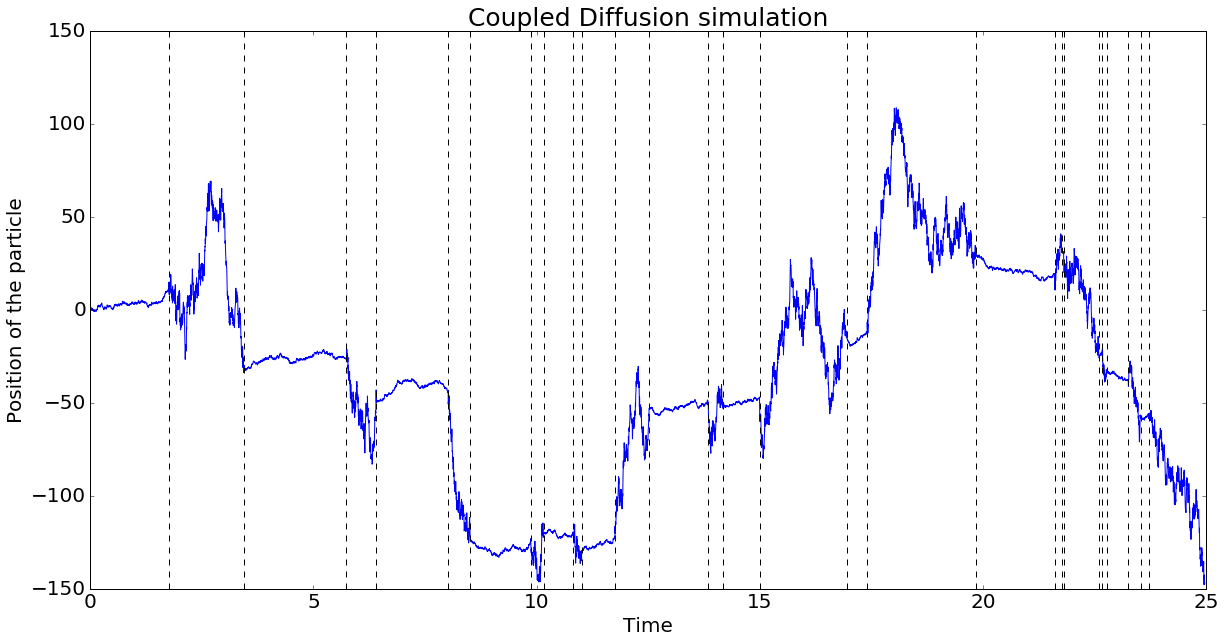

In [7]:
figure(figsize = (20,10))
plot(times, X)
rcParams.update({'font.size': 20})
xlabel("Time", fontsize = 20)
ylabel("Position of the particle", fontsize = 20)
title("Coupled Diffusion simulation", fontsize = 25)
for marker in delete(swtimes,-1):                                     # Inidicates the time of switching
    plt.axvline(x = marker,color = 'black', linestyle = '--')
savefig('Cdiff.png',transparent=True, bbox_inches='tight', pad_inches=0)